In [1]:
# define relevants paths and load functions and libraries

#%run Bianchini2025_SC\\Analysis\\helper_functions\\functions_analysis.py
    
data_path = 'Bianchini2025_SC\\Datasets\\' # your data path
saving_path = 'Bianchini2025_SC\\Figures_output\\' # your saving figures path

In [16]:
%run C:\\Users\\bianchg\\Documents\\GitHub\\Bianchini2025_SC\\Analysis\\helper_functions\\functions_analysis.py

data_path = 'Z:\\home\\shared\\Gaia\\Coliseum\\Delays\\paper_code\\Datasets\\' 
saving_path = 'C:\\Users\\bianchg\\Documents\\GitHub\\Bianchini2025_SC\\Figures_output\\'

In [3]:
# load the CCG dataset

file = ''.join([data_path,'connectivity_dataset\\CCG_dataset_baseline_RF_mapping.mat'])
CCG_dict = mat73.loadmat(file)
all_ccg = CCG_dict['all_ccg']

for k in all_ccg.keys():
    globals()[k] = all_ccg[k]
    
connection_strength = np.copy(peaks)
#check keys available
print(all_ccg.keys())

dict_keys(['corrected_CCG', 'pair_3D_dist', 'pair_distance_depth', 'pair_ids', 'pair_meanAP_pos', 'pair_meanML_pos', 'pair_meandepth_pos', 'pair_modality', 'pair_positions_depth', 'peak_lag', 'peaks', 'post_id', 'post_mean_FR', 'post_modality', 'post_pair_positions_3D', 'pre_id', 'pre_mean_FR', 'pre_modality', 'pre_pair_positions_3D', 'sess_n', 'sig_idx_4sd', 'sig_idx_5sd', 'sig_idx_6sd', 'sig_idx_7sd', 'trough_lag', 'troughs'])


In [4]:
# Plot second section of Figure 1 - RF mapping
# this uses a second dataset that needs to be loaded 

# load dataset
file=''.join([data_path,'neurons_datasets\\retinotopy_dataset.mat'])
data_dict = mat73.loadmat(file)
DAT=data_dict['retinotopy_dataset']

#check keys available
print(DAT.keys())

#I want to extract all keys in DAT and have them as arrays
for k in DAT.keys():
    globals()[k] = DAT[k]

dict_keys(['AUD', 'AUD_coords', 'AUD_fits_interp', 'AUD_peaks', 'AUD_r', 'AV', 'MULTI', 'MULTI_coords', 'MULTI_fits_interp', 'MULTI_peaks', 'VIS', 'VIS_coords', 'VIS_fits_interp', 'VIS_peaks', 'VIS_r', 'animal_ID', 'coord3D', 'experiment_ID', 'locs', 'n_col', 'n_rows', 'neuron_ID', 'slices_degrees', 'stims'])


In [5]:
# update the modality of the neurons accordingly 
modality = ((AUD | VIS | AV)).astype(int)

vis_pos = np.argwhere(VIS>0)[:,0]
aud_pos = np.argwhere(AUD>0)[:,0]
audvis_pos = np.argwhere(AV>0)[:,0]

new_modality = np.zeros((modality.shape[0],1))
new_modality[vis_pos] = 1
new_modality[aud_pos] = 2
new_modality[audvis_pos] = 3

indices = pre_id.astype(int) - 1
# Use modality as a lookup table
pre_modality = new_modality[indices][:,0]

indices = post_id.astype(int) - 1
# Use modality as a lookup table
post_modality = new_modality[indices][:,0]

In [6]:
# function to calculate and plot the correlation probability for both pairs and stim pairs
def calculate_probability(pair_distance, over_tot, sig_indices, bin_width = 50, lag_sign=None):

    min_val = np.nanmin(pair_distance)
    max_val = np.nanmax(pair_distance)
    n_bins = int(np.round((max_val - min_val) / bin_width))

    idA, edges = makeBins_SC(pair_distance, n_bins)

    idB = idA[over_tot]
    if lag_sign is not None:
        sig_lag_sign = lag_sign[sig_indices]
        pairs_connected = sig_indices[sig_lag_sign != 0]
        idC = idA[pairs_connected]
    else:
        idC = idA[sig_indices]

    perc = []
    for b in range(1, n_bins + 1):
        tot = idB[idB == b].shape[0]
        sig = idC[idC == b].shape[0]
        if tot == 0:
            perc.append(float('nan'))
        elif sig == 0:
            perc.append(0)
        else:
            perc.append((sig / tot) * 100)

    return edges, perc, max_val

In [7]:
# assess probability of correlation and connection

min_FR = 10#10 #Hz
sig_idx = sig_idx_5sd # peak a SD

# Significant pair indices based on statistical significance + modality
sig_indices = np.where(
    (sig_idx == 1) &
    (pre_modality >= 1) &
    (post_modality >= 1)
)[0]

# Total pair indices that pass basic modality threshold
over_tot = np.where(
    (pre_modality > 0) &
    (post_modality > 0)
)[0]


# Every pair is one row: keep as-is, no [::2]
sig_pairs = sig_indices
tot_pairs = over_tot

# Define directionality
lag_sign = np.zeros(peak_lag.shape[0])
lag_sign[peak_lag >= 10] = 1
lag_sign[peak_lag <= -10] = -1

# Direction of only significant pairs
sig_lag_sign = lag_sign[sig_indices]
pairs_connected = sig_indices[sig_lag_sign != 0]
pairs_simultanous = sig_indices[sig_lag_sign == 0]

# Connection flag for all pairs
is_connected = np.zeros(pair_ids.shape[0], dtype=bool)
is_connected[pairs_connected] = True # lag >1ms

In [9]:
# compute correlation matrix for multisensory RF

all_norm_data = np.zeros((MULTI_peaks.shape[0],MULTI_peaks.shape[1]))

for n in range(MULTI_peaks.shape[0]):
    RF = MULTI_peaks[n,:]
    norm_data = (RF - np.nanmin(RF)) / (np.nanmax(RF) - np.nanmin(RF))
    
    all_norm_data[n,:] = norm_data
    
corr_matrix_av = np.corrcoef(all_norm_data)

In [13]:
# Zero-based indices for significant pairs
ids_sig_pairs = (pair_ids[pairs_connected, :] - 1).astype(int)
correlation_values_sign = corr_matrix_av[ids_sig_pairs[:, 0], ids_sig_pairs[:, 1]]
sess_for_sig_pairs = sess_n[pairs_connected]  # sessions for significant pairs (using first neuron)

non_sig_pairs = np.setdiff1d(tot_pairs, pairs_connected)
ids_non_sig_pairs = (pair_ids[non_sig_pairs, :] - 1).astype(int)
correlation_values_non_sign = corr_matrix_av[ids_non_sig_pairs[:, 0], ids_non_sig_pairs[:, 1]]
sess_for_non_sig_pairs = sess_n[non_sig_pairs]  # sessions for non-significant pairs

# Dictionaries to hold correlations by session
sig_corrs_by_session = {}
non_sig_corrs_by_session = {}

# Unique sessions present in either sig or non-sig pairs
unique_sessions = np.unique(np.concatenate([sess_for_sig_pairs, sess_for_non_sig_pairs]))

for sess in unique_sessions:
    # Significant correlations for this session
    mask_sig = sess_for_sig_pairs == sess
    sig_corrs_by_session[sess] = correlation_values_sign[mask_sig]

    # Non-significant correlations for this session
    mask_non_sig = sess_for_non_sig_pairs == sess
    non_sig_corrs_by_session[sess] = correlation_values_non_sign[mask_non_sig]
    
# Combine correlation values
all_sig_corrs = np.concatenate([np.array(v).flatten() for v in sig_corrs_by_session.values()])
all_non_sig_corrs = np.concatenate([np.array(v).flatten() for v in non_sig_corrs_by_session.values()])

df = pd.DataFrame({
    "correlation": np.concatenate([all_sig_corrs, all_non_sig_corrs]),
    "significance": ["significant"] * len(all_sig_corrs) + ["non-significant"] * len(all_non_sig_corrs)
})

# save it to be plotted
save_dir = ''.join([data_path,'connectivity_dataset\\RF_correlation_connected_vs_notconnected.csv'])
df.to_csv(save_dir,index=False)


In [14]:
def sessionwise_shuffled_conn_prob(
    sess_n, is_connected, pair_corrs, bins, n_boot=1000
):
    n_bins = len(bins) - 1

    # Mapping: session → list of indices
    session_to_indices = defaultdict(list)
    for i, s in enumerate(sess_n):
        session_to_indices[s].append(i)

    # Observed connection probabilities
    conn_prob_obs = []
    n_total = []
    n_connected = []
    for i in range(n_bins):
        if i == 0:
            in_bin = pair_corrs <= bins[i + 1]
        elif i == n_bins - 1:
            in_bin = pair_corrs >= bins[i]
        else:
            in_bin = (pair_corrs >= bins[i]) & (pair_corrs < bins[i + 1])

        total = np.sum(in_bin)
        connected = np.sum(is_connected[in_bin])
        n_total.append(total)
        n_connected.append(connected)
        conn_prob_obs.append((connected / total) * 100 if total > 0 else np.nan)
    conn_prob_obs = np.array(conn_prob_obs)

    # Null distribution: shuffle correlations only within each session
    conn_prob_null = np.empty((n_boot, n_bins))

    for b in range(n_boot):
        shuffled_corrs = np.copy(pair_corrs)

        for s, indices in session_to_indices.items():
            idx = np.array(indices)
            if len(idx) > 1:
                shuffled_corrs[idx] = np.random.permutation(pair_corrs[idx])

        for i in range(n_bins):
            if i == 0:
                in_bin = shuffled_corrs <= bins[i + 1]
            elif i == n_bins - 1:
                in_bin = shuffled_corrs >= bins[i]
            else:
                in_bin = (shuffled_corrs >= bins[i]) & (shuffled_corrs < bins[i + 1])

            total = np.sum(in_bin)
            connected = np.sum(is_connected[in_bin])
            conn_prob_null[b, i] = (connected / total) * 100 if total > 0 else np.nan

    return {
        "conn_prob_obs": conn_prob_obs,
        "conn_prob_null": conn_prob_null,
        "n_total": n_total,
        "n_connected": n_connected,
    }

In [24]:
# Stack correlations

exp_to_animal = {}
for exp, animal in zip(experiment_ID, animal_ID):
    exp_to_animal[exp] = animal
sess_n_int = sess_n.astype(int)
animal_n = np.array([exp_to_animal[exp] for exp in sess_n_int])

pair_corrs = np.concatenate([correlation_values_sign, correlation_values_non_sign])
is_connected = np.concatenate([np.ones_like(correlation_values_sign, dtype=bool),
                               np.zeros_like(correlation_values_non_sign, dtype=bool)])
sess_n = np.concatenate([sess_for_sig_pairs, sess_for_non_sig_pairs])

bins = np.arange(-0.1, 0.9, 0.1)

results = sessionwise_shuffled_conn_prob(
    sess_n=sess_n,
    is_connected=is_connected,
    pair_corrs=pair_corrs,
    bins=bins,
    n_boot=1000  # or however many bootstraps you want
)

# save it to be plotted
results["n_pairs_connected"] = pairs_connected.shape[0]
results["n_pairs_total"] = tot_pairs.shape[0]
results["bins"] = bins
save_path = data_path + 'connectivity_dataset\\RF_correlation_as_function_connectivity.npz'
np.savez(save_path, **results)


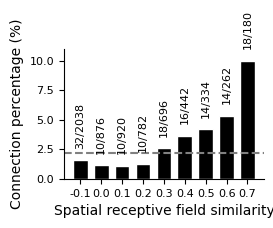

In [22]:
conn_prob_obs = results["conn_prob_obs"]
conn_prob_null = results["conn_prob_null"]

n_total = results["n_total"]
n_connected = results["n_connected"]

bin_centers = (bins[:-1] + bins[1:]) / 2
bar_width = 0.07
offset = bar_width / 2

fig, ax = plt.subplots(1,1,figsize=(2,1.3))

plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

conn_prob_null_mean = np.nanmean(conn_prob_null, axis=0)
conn_prob_null_sem = np.nanstd(conn_prob_null, axis=0) / np.sqrt(np.sum(~np.isnan(conn_prob_null), axis=0))
conn_prob_null_iqr = (np.nanpercentile(conn_prob_null, 75, axis=0) - 
                      np.nanpercentile(conn_prob_null, 25, axis=0)) / 2

# Plot mean as a line
#ax.plot(bin_centers, conn_prob_null_mean, color='gray', label='Randomised mean')
mean_conn_prob = (pairs_connected.shape[0] / tot_pairs.shape[0]) * 100
ax.axhline(y=mean_conn_prob, linestyle='--', color='grey', label='Mean connection rate')

# Plot observed connection probabilities as bars
bars = ax.bar(bin_centers, conn_prob_obs, width=bar_width, color='black',
              edgecolor='white', label='Observed', zorder=1)

lower_bound = conn_prob_null_mean - conn_prob_null_iqr
upper_bound = conn_prob_null_mean + conn_prob_null_iqr

# Plot shaded IQR area
#ax.fill_between(bin_centers, lower_bound, upper_bound, color='gray', alpha=0.5, label='IQR')


# Add text labels and significance stars
for i, bar in enumerate(bars):
    if n_total[i] > 0:
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 1,
                f"{n_connected[i]}/{n_total[i]}",
                ha='center', va='bottom', fontsize=8, rotation=90)


# Plot aesthetics
ax.set_xticks(bin_centers)
ax.set_xticklabels([f"{b:.1f}" for b in bins[:-1]])
ax.set_xlabel("Spatial receptive field similarity")
ax.set_ylabel("Connection percentage (%)")
ax.set_ylim(0, max(np.nanmax(conn_prob_obs), np.nanmax(conn_prob_null_mean)) + 1)
#ax.set_ylim([0,5])
#ax.set_yticks([0,5,10,15,20])
ax.tick_params(axis='y', labelsize=8)

ax.tick_params(axis='x', labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

dir = ''.join([saving_path,'Figure3D.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)

In [190]:
connected_counts = np.array(n_connected)
total_counts = np.array(n_total)
not_connected = total_counts - connected_counts

counts_matrix = np.column_stack((connected_counts, total_counts - connected_counts))

# conn_prob_null: shape (n_boot, n_bins)
# Make sure it's a NumPy array
conn_prob_null = np.asarray(conn_prob_null)

# Save to .mat file
scipy.io.savemat(''.join([data_path,'connectivity_dataset\\RF_connectivity_cochran_data.mat']), {
    'counts_matrix': counts_matrix,
    'conn_prob_null': conn_prob_null
})